In [2]:
# predictive_maintenance.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [9]:
# 1. Load data
df = pd.read_csv("ai4i2020.csv")
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [10]:
# 2. Basic cleaning
df = df.drop(columns=['UDI', 'Product ID'])
df['Target'] = df['Machine failure']  # rename for clarity
df = df.drop(columns=['Machine failure'])

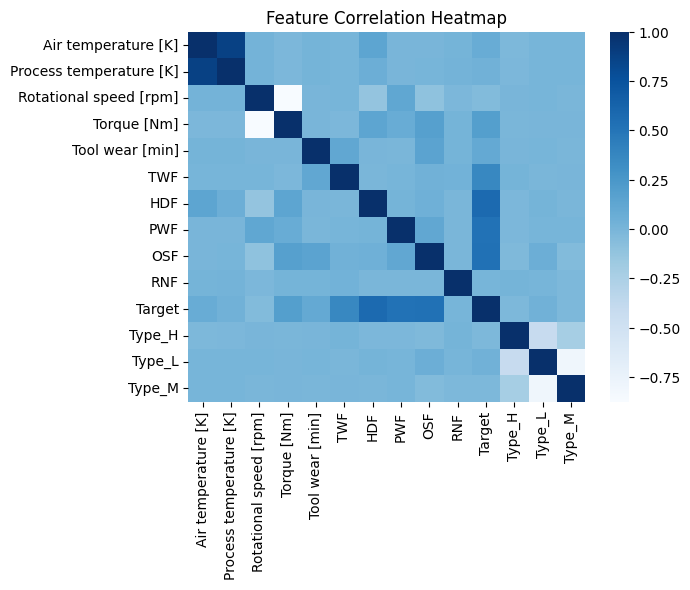

In [11]:
# 3. EDA
# Apply one-hot encoding to the 'Type' column
df_encoded = pd.get_dummies(df, columns=['Type'], prefix='Type')

sns.heatmap(df_encoded.corr(), cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# 4. Split data
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# 5. Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 0.9808588168652086


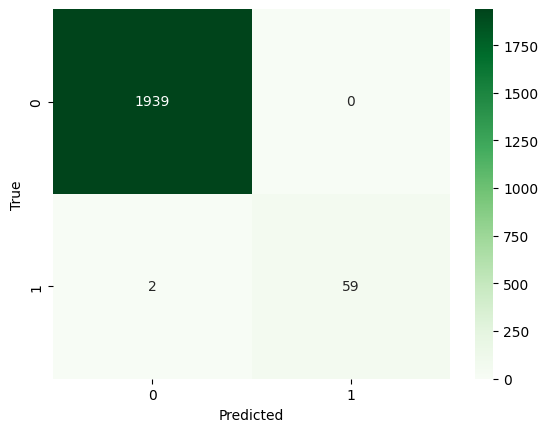

In [14]:
# 6. Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

In [15]:
!pip install joblib -q
import joblib
from sklearn.ensemble import RandomForestClassifier

# retrain (or load your trained model)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# save with joblib
joblib.dump(model, "rf_model.joblib")


['rf_model.joblib']

In [16]:
%%writefile app.py
import streamlit as st
import numpy as np
try:
    import joblib
except ImportError:
    import os
    os.system("pip install joblib")
    import joblib
model = joblib.load("rf_model.joblib")

import joblib
import os

st.title("🚗 BMW Predictive Maintenance AI App")

st.write("Files in directory:", os.listdir("."))

try:
    model = joblib.load("rf_model.joblib")
    st.success("✅ Model loaded successfully.")
except Exception as e:
    st.error(f"Model failed to load: {e}")
    st.stop()

# ---- prediction UI ----
air_temp = st.slider("Air Temperature [K]", 290, 320, 300)
process_temp = st.slider("Process Temperature [K]", 300, 350, 320)
torque = st.slider("Torque [Nm]", 0, 80, 40)
rot_speed = st.slider("Rotational Speed [rpm]", 1000, 3000, 1500)
tool_wear = st.slider("Tool Wear [min]", 0, 250, 50)

features = np.array([[air_temp, process_temp, torque, rot_speed, tool_wear]])

if st.button("🔍 Predict Maintenance Status"):
    pred = model.predict(features)[0]
    if pred == 1:
        st.error("⚠️ Maintenance Needed Soon!")
    else:
        st.success("✅ Vehicle Operating Normally")



Overwriting app.py


In [17]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.8 MB/s eta 0:00:00


In [18]:
# Install dependencies
!pip install streamlit pyngrok -q

# Import libraries
from pyngrok import ngrok

!ngrok authtoken 34y7IYFDcuSMQnLcDLr1nTwsFrQ_9vGiGx8vnkd4FMAXCnFY

# Run Streamlit in the background
!streamlit run app.py &>/dev/null&

# Create tunnel to access Streamlit app
public_url = ngrok.connect(8501)
print("✨ Your Streamlit app is live here:", public_url)


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
✨ Your Streamlit app is live here: NgrokTunnel: "https://seely-marivel-uncourting.ngrok-free.dev" -> "http://localhost:8501"
